
# **This notebook contains the computations and plots used to solve the assignment**


In [2]:
## 
#  This cell cleans the environment whenever is needed
#  
rm(list = ls())

In [3]:
## 
#  This cell installs the library packages used
#  Uncomment if necessary
#
# install.packages(c("readxl", "ggplot2", "moments", "matlib", "zoo"))

In [7]:
## 
#  This cell loads the libraries needed
#  @library readxl to read excel files
#  @library moments to compute statistics
#  @library zoo to compute correlations in rolling windows
library(readxl)
library(moments)
library(zoo)

source('portConstruct.R')

In [5]:
## 
#  This cell loads and processees the given data
#  @param data.xslx as the data time series set provided 
#  @param sheet "csv" that has the raw data
#  @return data data set cleaned and in decimals for the respective variabes
##
data                                      <- read_excel("data.xlsx", sheet = "csv")

# Changes the name of the column "Date" to "date"
names(data)[names(data) == "Date"]        <- "date"

# Transforms the date column to date format
data$date                                 <- as.Date(data$date, format = "%Y-%m-%d")

# Selects only the columns that are expressed in pertecentage and divides by 100 to get raw values
nonPercentageColumns                      <- c("date", "P/D", "P/E")
data[, !(names(data) %in% nonPercentageColumns)] <- data[, !(names(data) %in% nonPercentageColumns)] / 100

[1] "--------------------------------QUESTION 2.1--------------------------------"

[1] "The mean of the benchmark portfolio real returns is 0.0046"

[1] "The variance of the benchmark portfolio real returns is 9e-04"

[1] "The fund's relative risk aversion (gamma = mean / variance) is 5.12"

[1] "--------------------------------QUESTION 2.2--------------------------------"

[1] "The CE of the benchmark portfolio without the risk free rate asset is 0.0023"

[1] "The CE of the benchmark portfolio with the risk free rate asset is 0.0023"

[1] "The improvement from introducing the riskfree rate asset is 0"

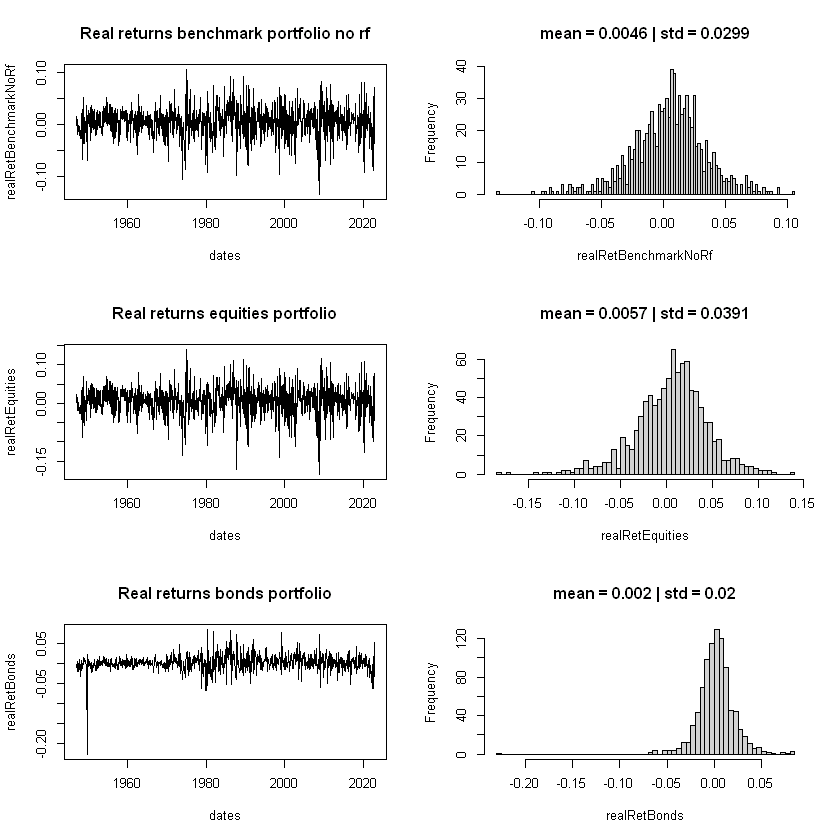

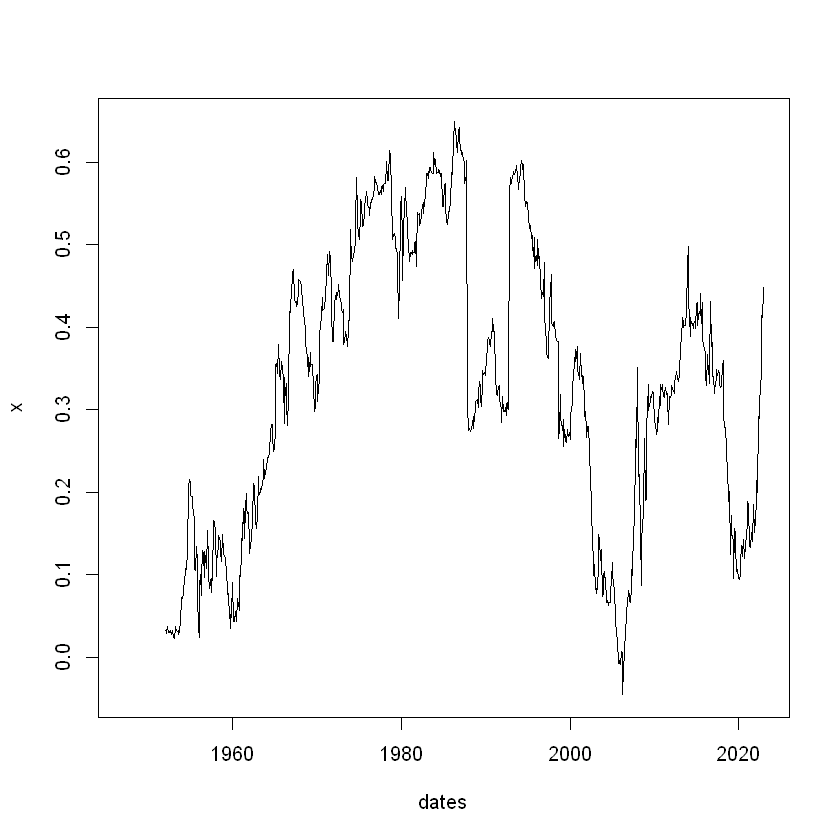

In [ ]:
## This cell solves question 2 Mean Variance-Analysis
#  @param date the time series formated date
#  @param riskFreeRate U.S. 1-month Treasury bill rate (series 3)
#  @param inflation the Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (series 37) 
#  @param equities the world equity portfolio (series 31)
#  @param bonds world government bonds portfolio (series 32)
#  @return dataMV dataset containing the principal variables used in the benchmark portfolio
##
variablesSelected <- c("date", "us_t1m", "us_infl", "wrld_eq", "wlrd_gbnd")
dataMV            <- data[, variablesSelected]
newColumnNames    <- c("date", "riskFreeRate", "inflation", "equities", "bonds")
colnames(dataMV)  <- newColumnNames

## Compute the nominal returns and real returns of the benchmark strategy
#  @param dates as the dates containing the information
#  @param nominalRetEquities the nominal returns on the equity portfolio
#  @param nominalRetBonds the nominal returns on bonds portfolio
#  @param inflation the CPI used to get real returns
#  @param weightInEquities the strategy weight in equities
#  @param weightInBonds the strategy's weight in bonds
#  @return nominalRetBenchmarkNoRf as the nominal return considering the weights
#  @return realRetBenchmarkNoRf as the real return adjusted to inflation
#
dates                   <- dataMV$date[-1]
nominalRetEquities      <- dataMV$equities[-1]
nominalRetBonds         <- dataMV$bonds[-1]
inflation               <- dataMV$inflation[-1]
weightInEquities        <- 0.70
weightInBonds           <- 0.30
nominalRetBenchmarkNoRf <- weightInEquities*nominalRetEquities + weightInBonds*nominalRetBonds
realRetBenchmarkNoRf    <- (1 + nominalRetBenchmarkNoRf) / (1 + inflation) - 1

## Infer the fund’s relative risk aversion,assume real returns and no risk-free asset
#  Weight in risky assets is 100% in this case
#  @param realRetBenchmarkNoRf the real returns of the strategy
#  @return meanBenchmarkNoRf of the real returns of the benchmark portfolio
#  @return varBenchmarkNoRf of the real returns of the benchmark portfolio
#  @return gammaBenchmark as solving for relative risk aversion
#
meanBenchmarkNoRf <- mean(realRetBenchmarkNoRf)
varBenchmarkNoRf  <- var(realRetBenchmarkNoRf)
stdBenchmarkNoRf  <- sd(realRetBenchmarkNoRf)
weightRiskyAssets <- 1.00
gammaBenchmark    <- 1/weightRiskyAssets * meanBenchmarkNoRf/varBenchmarkNoRf 
paste("--------------------------------QUESTION 2.1--------------------------------")
paste("The mean of the benchmark portfolio real returns is", round(meanBenchmarkNoRf,4))
paste("The variance of the benchmark portfolio real returns is", round(varBenchmarkNoRf,4))
paste("The fund's relative risk aversion (gamma = mean / variance) is", round(gammaBenchmark, 2))

## Make reference of the two momments of the two assets vs portfolio
#  Use real returns
#  @param inflation to compute real returns
#  @param nominalRetEquities
#  @param nominalRetBonds
#  @param realRetBenchmarkNoRf
#  @return meanEquities adjusted to inflation
#  @return meanBonds adjusted to inflation
#  @return varEquities adjusted to inflation
#  @return varBonds
#  @return plot with historgrams of realRetEquities + realRetBonds and realRetBenchmarkNoRf
#
realRetEquities <- (1 + nominalRetEquities) / (1 + inflation) - 1
realRetBonds    <- (1 + nominalRetBonds)    / (1 + inflation) - 1
meanEquities    <- mean(realRetEquities)
meanBonds       <- mean(realRetBonds)
varEquities     <- var(realRetEquities)
varBonds        <- var(realRetBonds)
stdEquities     <- sd(realRetEquities)
stdBonds        <- sd(realRetBonds)

# Set titles
par(mfrow = c(3, 2))
t1a <- paste("Real returns benchmark portfolio no rf")
t1b <- paste("mean =", round(meanBenchmarkNoRf, 4), "| std =", round(stdBenchmarkNoRf, 4))
t2a <- paste("Real returns equities portfolio")
t2b <- paste("mean =", round(meanEquities, 4), "| std =", round(stdEquities, 4))
t3a <- paste("Real returns bonds portfolio")
t3b <- paste("mean =", round(meanBonds, 4), "| std =", round(stdBonds, 4))

# Plot benchmark
plot(dates, realRetBenchmarkNoRf, type = "l", main = t1a)
hist(realRetBenchmarkNoRf, breaks = 100, main = t1b)

# Plot Equities
plot(dates, realRetEquities, type = "l", main = t2a)
hist(realRetEquities, breaks = 100, main = t2b)

# Plot Bonds
plot(dates, realRetBonds, type = "l", main = t3a)
hist(realRetBonds, breaks = 100, main = t3b)


## Computes the optimal portfolio weights
#  @param meanBenchmarkNoRf
#  @param varBenchmarkNoRf
#  @param riskFreeRate
#  @param gammaBenchmark
#  @param realRetBenchmarkNoRf
#  @return certEqBenchmarkNoRf
#  @return meanBenchmarkWithRf
#  @rerurn varBenchmarkWithRf
#  @return certEqBenchmarkWithRf
#
riskFreeRate           <- dataMV$riskFreeRate[-1]
realRiskFreeRateSeries <- (1 + riskFreeRate) / (1 + inflation) - 1
realRiskFreeRate       <- mean(realRiskFreeRateSeries)
certEqBenchmarkNoRf    <- meanBenchmarkNoRf - (gammaBenchmark/2) * varBenchmarkNoRf

# Compute the Certainity Equivalent for the benchmark ptf with rf asset
weightRiskyAssets      <- (meanBenchmarkNoRf - realRiskFreeRate) / (gammaBenchmark*varBenchmarkNoRf)
realRetBenchmarkWithRf <- weightRiskyAssets * realRetBenchmarkNoRf + (1 - weightRiskyAssets)*realRiskFreeRateSeries
meanBenchmarkWithRf    <- mean(realRetBenchmarkWithRf)
varBenchmarkWithRf     <- var(realRetBenchmarkWithRf)
stdBenchmarkWithRf     <- sd(realRetBenchmarkWithRf)
certEqBenchmarkWithRf  <- meanBenchmarkWithRf - (gammaBenchmark/2) * varBenchmarkWithRf 
certEqImprovement      <- certEqBenchmarkWithRf - certEqBenchmarkNoRf

# Present results
paste("--------------------------------QUESTION 2.2--------------------------------")
paste("The CE of the benchmark portfolio without the risk free rate asset is", round(certEqBenchmarkNoRf,4))
paste("The CE of the benchmark portfolio with the risk free rate asset is", round(certEqBenchmarkWithRf,4))
paste("The improvement from introducing the riskfree rate asset is", round(certEqImprovement, 5))


## rolling window for correlations
par(mfrow = c(1,1))
x <- rollapply(
  data = cbind(realRetEquities, realRetBonds),
  width = 60,
  FUN = function(x) cor(x[,1], x[,2]),
  by.column = FALSE,
  align = "right",
  fill = NA
)
plot(dates, x, type = "l")